In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function, division

In [3]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam

Using TensorFlow backend.


In [6]:
import os
import sys
base_module_path = os.path.abspath(os.path.join('..'))
if base_module_path not in sys.path:
    sys.path.append(base_module_path)
import ama as a

In [7]:
BASE_PATH = '../data/'

In [8]:
df = pd.read_csv(BASE_PATH + 'train_v2.csv'); print(len(df)); df.head()

40479


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
df['path'] = df['image_name'].map(lambda x: BASE_PATH + 'train-full-jpg/' + x + '.jpg'); df.head()

,image_name,tags,path
0,train_0,haze primary,../data/train-full-jpg/train_0.jpg
1,train_1,agriculture clear primary water,../data/train-full-jpg/train_1.jpg
2,train_2,clear primary,../data/train-full-jpg/train_2.jpg
3,train_3,clear primary,../data/train-full-jpg/train_3.jpg
4,train_4,agriculture clear habitation primary road,../data/train-full-jpg/train_4.jpg


In [10]:
# Build list with unique labels
label_list = []
for tag_str in df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
label_list      

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [11]:
# Add onehot features for every label
for label in label_list:
    df[label] = df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
df.head()

,image_name,tags,path,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,../data/train-full-jpg/train_0.jpg,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,../data/train-full-jpg/train_1.jpg,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,../data/train-full-jpg/train_2.jpg,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,../data/train-full-jpg/train_3.jpg,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,../data/train-full-jpg/train_4.jpg,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [12]:
def check_image(path):
    print(path)
    img = plt.imread(path)
    print(img.shape)
    plt.imshow(img)

../data/train-full-jpg/train_0.jpg
(256, 256, 4)


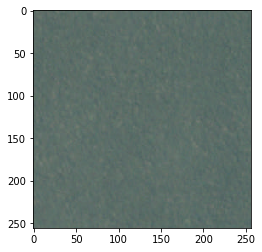

In [17]:
check_image(df.path[0])

In [18]:
### COMPUTE FEATURES ###
from PIL import Image, ImageStat
import scipy
import cv2

def get_features(path):
    st = []
    img = Image.open(path)
    im_stats_ = ImageStat.Stat(img)
    st += im_stats_.sum
    st += im_stats_.mean
    st += im_stats_.rms
    st += im_stats_.var
    st += im_stats_.stddev
    img = np.array(img)[:,:,:3]
    st += [scipy.stats.kurtosis(img[:,:,0].ravel())]
    st += [scipy.stats.kurtosis(img[:,:,1].ravel())]
    st += [scipy.stats.kurtosis(img[:,:,2].ravel())]
    st += [scipy.stats.skew(img[:,:,0].ravel())]
    st += [scipy.stats.skew(img[:,:,1].ravel())]
    st += [scipy.stats.skew(img[:,:,2].ravel())]
    #cv2 jpg
    img = cv2.imread(path)
    bw = cv2.imread(path,0)
    #st += list(cv2.calcHist([bw],[0],None,[256],[0,256]).flatten()) #bw 
    #st += list(cv2.calcHist([img],[0],None,[256],[0,256]).flatten()) #r
    #st += list(cv2.calcHist([img],[1],None,[256],[0,256]).flatten()) #g
    #st += list(cv2.calcHist([img],[2],None,[256],[0,256]).flatten()) #b
    m, s = cv2.meanStdDev(img) #mean and standard deviation
    st += list(list(m))
    st += list(s)
    st += [cv2.Laplacian(bw, cv2.CV_64F).var()] 
    st += [cv2.Laplacian(img, cv2.CV_64F).var()]
    st += [cv2.Sobel(bw,cv2.CV_64F,1,0,ksize=5).var()]
    st += [cv2.Sobel(bw,cv2.CV_64F,0,1,ksize=5).var()]
    st += [cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).var()]
    st += [cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).var()]
    st += [(bw<30).sum()]
    st += [(bw>225).sum()]
    return [path, st]

In [19]:
from multiprocessing import Pool, cpu_count
def normalize_img(paths):
    imf_d = {}
    p = Pool(cpu_count())
    ret = p.map(get_features, paths)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    return fdata

In [20]:
import cPickle as pickle

In [21]:
y = df.cloudy
y_mean = y.mean()
print(y.sum())
print(y.mean())
print(len(y))
print(y.sum()/len(y))

2089
0.0516070061019
40479
0.0516070061019


In [23]:
try:
    x = pickle.load( open(BASE_PATH+ 'features1.pkl', 'rb'))
    print("unpickling")
except:
    x = normalize_img(df['path']); print('train...')
    print("generating features - long...")

unpickling


In [43]:
x = np.array(x)
y = np.array(y)

In [46]:
print(x[:2])
print(y[:2])
print(x.shape)
print(y.shape)

[[  1.06963020e+07   9.54551500e+06   9.92155100e+06   0.00000000e+00
    1.63212616e+02   1.45653000e+02   1.51390854e+02   0.00000000e+00
    1.63268258e+02   1.45685460e+02   1.51412980e+02   0.00000000e+00
    1.81659151e+01   9.45687668e+00   6.69981808e+00   0.00000000e+00
    4.26214911e+00   3.07520352e+00   2.58840068e+00   0.00000000e+00
    8.92940216e-01   4.68080739e-01   5.84727109e-01  -3.49179090e-01
   -1.85761651e-01  -1.43464814e-01   1.04609146e+02   1.10347000e+02
    9.27873840e+01   2.58840068e+00   3.07520352e+00   4.26214911e+00
    1.31064139e+01   1.79296767e+01   1.91826548e+04   1.23779764e+04
    2.29763142e+04   1.55191538e+04   0.00000000e+00   0.00000000e+00]
 [  1.24099060e+07   1.16983480e+07   1.24976110e+07   0.00000000e+00
    1.89360138e+02   1.78502625e+02   1.90698410e+02   0.00000000e+00
    1.90216407e+02   1.79334565e+02   1.90935520e+02   0.00000000e+00
    3.25019684e+02   2.97699120e+02   9.04892589e+01   0.00000000e+00
    1.80283023e+01 

In [22]:
with open(BASE_PATH + 'features1.pkl', 'wb') as output:
    #pickle.dump(x, output)

In [32]:
### TPOT auto-ML ###
from tpot import TPOTClassifier
pipeline_optimizer = TPOTClassifier(generations=2, population_size=20, cv=5,
                                    random_state=42, verbosity=2)

In [49]:
i = 1000
pipeline_optimizer.fit(x[:i],y[:i])

Optimization Progress:  65%|██████▌   | 39/60 [00:16<00:14,  1.44pipeline/s]

Generation 1 - Current best internal CV score: 0.972009650241


Generation 2 - Current best internal CV score: 0.972009650241

Best pipeline: LinearSVC(input_matrix, LinearSVC__C=1.0, LinearSVC__dual=False, LinearSVC__loss=squared_hinge, LinearSVC__penalty=l1, LinearSVC__tol=DEFAULT)


TPOTClassifier(config_dict={'sklearn.ensemble.GradientBoostingClassifier': {'max_features': array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ]), 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0], 'min_samples_... 0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}, 'sklearn.preprocessing.RobustScaler': {}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        generations=2, max_eval_time_mins=5, max_time_mins=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=20, population_size=20,
        random_state=42, scoring=None, subsample=1.0, verbosity=2,
        warm_start=False)

In [48]:
print(pipeline_optimizer.score(,)

0.933817535018
